In [1]:
import os
# import drjit
gpu_num = 3 # Use "" to use the CPU
os.environ["CUDA_VISIBLE_DEVICES"] = f"{gpu_num}"
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
tf.get_logger().setLevel('ERROR')
# tf.config.run_functions_eagerly(True)
import sionna
import pickle

from jammer.simulation_model import *
from jammer.utils import *
import jammer.simulation_model as sim
from tensorflow.python.keras.losses import MeanAbsoluteError, MeanSquaredError, BinaryCrossentropy

## Time Domain Simulation

In [2]:
data = {}

## 

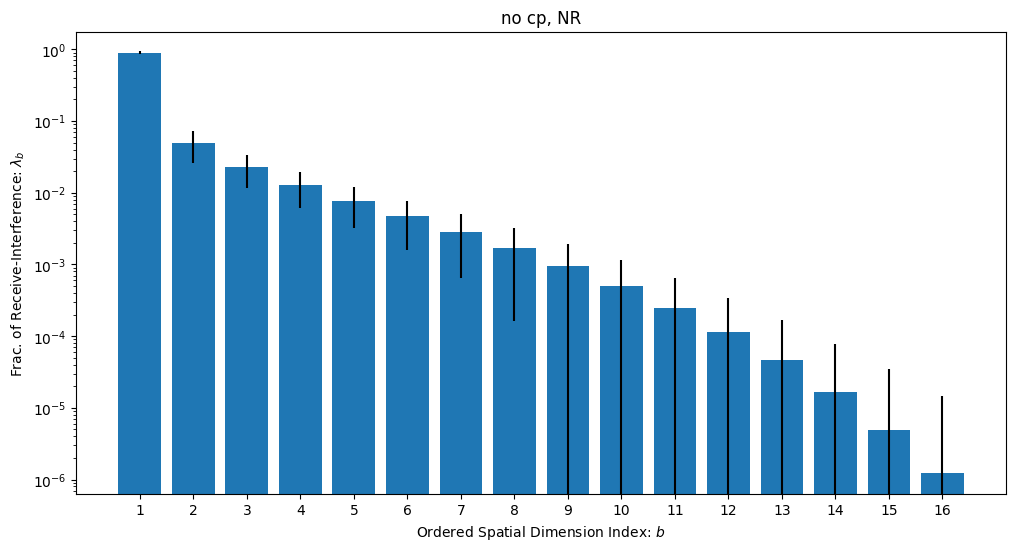

In [3]:
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["domain"] = "time"
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(60.)
model_parameters["jammer_mitigation"] = "pos"
model_parameters["num_silent_pilot_symbols"] = 50
model_parameters["num_ofdm_symbols"] = 53
model_parameters["return_jammer_signals"] = True
model_parameters["num_ut"] = 1
model_parameters["num_ut_ant"] = 1
jammer_parameters["num_tx"] = 1
jammer_parameters["num_tx_ant"] = 1
#NR compliant
model_parameters["carrier_frequency"] = 3.5e9
model_parameters["fft_size"] = 667 # * 30kHz = 20MHz
model_parameters["cyclic_prefix_length"] = 47 # 667 * 144 / 2048
model_parameters["subcarrier_spacing"] = 30e3

ebno_db = 100.0
BATCH_SIZE = 1
name = "Multiple Jammers"

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

# list of (batch_size, fft_size, num_rx*num_rx_ant)
rel_svs = []
model = Model(**model_parameters)
for i in range(20000):
    if i % 100 == 0:
        print(i, end='\r')
    b, llr, jammer_signals = model(BATCH_SIZE, ebno_db)
    rel_svs.append(relative_singular_values(jammer_signals))
rel_svs = tf.stack(rel_svs)
mean = tf.reduce_mean(rel_svs, axis=0)
std = tf.math.reduce_std(rel_svs, axis=0)
data["no cp, NR"] = (mean, std)

#log scale
ax.set_yscale("log")

x_labels = np.arange(len(mean), dtype=np.int32) + 1
ax.bar(x_labels, mean, yerr=std)
ax.set_xticks(x_labels)
ax.set_ylabel(r"Frac. of Receive-Interference: $\lambda_b$")
ax.set_xlabel(r"Ordered Spatial Dimension Index: $b$")
ax.set_title("no cp, NR")
# ax.set_title("Jammer Interference: Singular Values")

plt.show()
with open("bers/paper/singular_values.pickle", "wb") as f:
    pickle.dump(data, f)

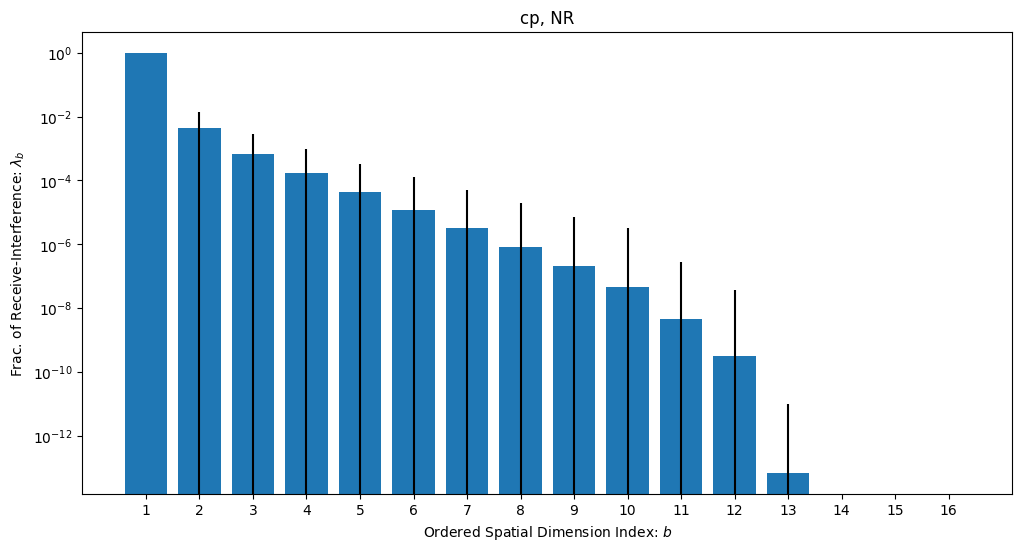

In [4]:
model_parameters = {}
jammer_parameters = {}
model_parameters["jammer_parameters"] = jammer_parameters

model_parameters["domain"] = "time"
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(60.)
model_parameters["jammer_mitigation"] = "pos"
model_parameters["num_silent_pilot_symbols"] = 50
model_parameters["num_ofdm_symbols"] = 53
model_parameters["return_jammer_signals"] = True
model_parameters["num_ut"] = 1
model_parameters["num_ut_ant"] = 1
jammer_parameters["num_tx"] = 1
jammer_parameters["num_tx_ant"] = 1
jammer_parameters["send_cyclic_prefix"] = True
#NR compliant
model_parameters["carrier_frequency"] = 3.5e9
model_parameters["fft_size"] = 667 # * 30kHz = 20MHz
model_parameters["cyclic_prefix_length"] = 47 # 667 * 144 / 2048
model_parameters["subcarrier_spacing"] = 30e3

ebno_db = 100.0
BATCH_SIZE = 1
name = "Multiple Jammers"

fig, ax = plt.subplots()
fig.set_size_inches(12, 6)

rel_svs = []
model = Model(**model_parameters)
for i in range(20000):
    if i % 100 == 0:
        print(i, end='\r')
    b, llr, jammer_signals = model(BATCH_SIZE, ebno_db)
    rel_svs.append(relative_singular_values(jammer_signals))
rel_svs = tf.stack(rel_svs)
mean = tf.reduce_mean(rel_svs, axis=0)
std = tf.math.reduce_std(rel_svs, axis=0)
data["cp, NR"] = (mean, std)

#log scale
ax.set_yscale("log")

x_labels = np.arange(len(mean), dtype=np.int32) + 1
ax.bar(x_labels, mean, yerr=std)
ax.set_xticks(x_labels)
ax.set_ylabel(r"Frac. of Receive-Interference: $\lambda_b$")
ax.set_xlabel(r"Ordered Spatial Dimension Index: $b$")
ax.set_title("cp, NR")
# ax.set_title("Jammer Interference: Singular Values")

plt.show()
with open("bers/paper/singular_values.pickle", "wb") as f:
    pickle.dump(data, f)

EbNo [dB] |        BER |       BLER |  bit errors |    num bits | block errors |  num blocks | runtime [s] |    status
---------------------------------------------------------------------------------------------------------------------------------------
    -10.0 | 2.4350e-01 | 1.0000e+00 |  2494710765 | 10245120000 |       320000 |      320000 |      2014.9 |reached max iter       
     -9.0 | 2.0910e-01 | 1.0000e+00 |  2142257216 | 10245120000 |       320000 |      320000 |      1991.3 |reached max iter       
     -8.0 | 1.7476e-01 | 1.0000e+00 |  1790401314 | 10245120000 |       320000 |      320000 |      2011.7 |reached max iter       
     -7.0 | 1.4164e-01 | 1.0000e+00 |  1451096975 | 10245120000 |       320000 |      320000 |      2017.3 |reached max iter       
     -6.0 | 1.1086e-01 | 1.0000e+00 |  1135803585 | 10245120000 |       320000 |      320000 |      2032.2 |reached max iter       
     -5.0 | 8.3482e-02 | 1.0000e+00 |   855283593 | 10245120000 |       320000 |     

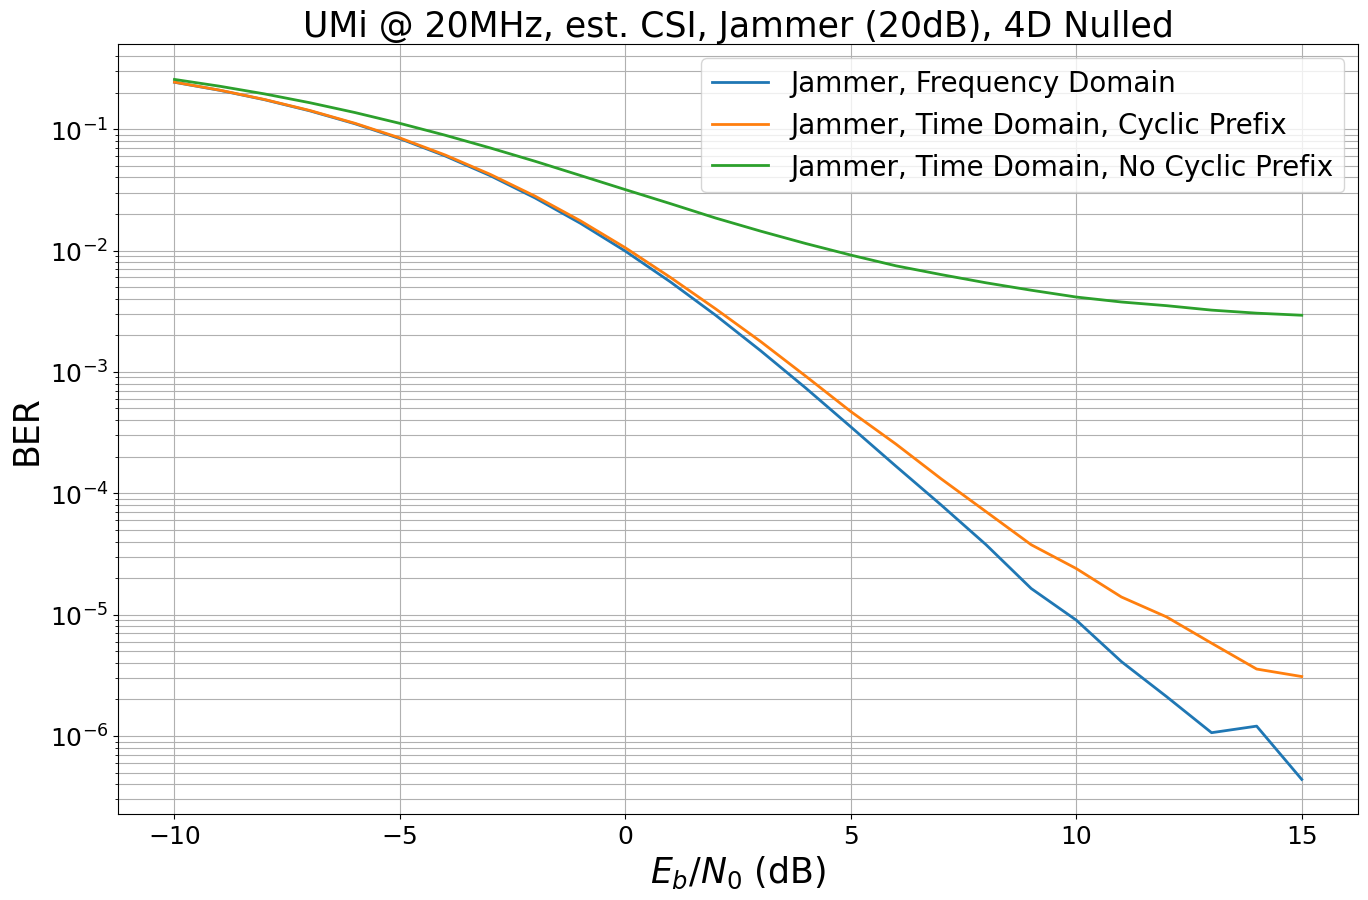

In [2]:
# here real est. CSI & NR compliant
ber_plots.reset()
model_parameters = {}
jammer_parameters = {}
model_parameters["num_ut"] = 4
model_parameters["jammer_parameters"] = jammer_parameters
model_parameters["num_silent_pilot_symbols"] = 4
model_parameters["jammer_present"] = True
model_parameters["jammer_power"] = db_to_linear(20.)
model_parameters["jammer_mitigation"] = "pos"
model_parameters["scenario"] = "umi"
#NR
model_parameters["fft_size"] = 667 # * 30kHz = 20MHz
model_parameters["cyclic_prefix_length"] = 47 # 667 * 144 / 2048
# sim.BATCH_SIZE = 30
sim.BATCH_SIZE = 128
sim.MAX_MC_ITER = 2500
# sim.ebno_dbs = np.linspace(-10., 15., 10)
sim.ebno_dbs = np.linspace(-10., 15., 26)

model = Model(**model_parameters)
simulate_model(model, "Jammer, Frequency Domain")

sim.BATCH_SIZE = 1
sim.MAX_MC_ITER = 50000

model_parameters["domain"] = "time"
jammer_parameters["send_cyclic_prefix"] = True
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, Cyclic Prefix")

jammer_parameters["send_cyclic_prefix"] = False
model = Model(**model_parameters)
simulate_model(model, "Jammer, Time Domain, No Cyclic Prefix")

ber_plots.title = "UMi @ 20MHz, est. CSI, Jammer (20dB), 4D Nulled"
ber_plots()
with open("bers/paper/time_pos_umi_nr_est_4ue.pickle", 'wb') as f:
    bers = pickle.dump(ber_plots, f)